In [1]:
import numpy as np
from matplotlib    import pyplot as plt
from numpy.random  import default_rng
from tqdm          import tqdm
from time          import perf_counter 
from scipy.stats   import rice, foldnorm
from dw_tools      import dag_pgm_tools, draw_tree
import networkx 
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import reciprocalspaceship as rs
import gemmi

# for daft, see https://docs.daft-pgm.org/en/latest/

In [2]:
plt.rcParams.update({'font.size': 12})
%load_ext autoreload
%autoreload 2

# The general case: any number of sets of related structure factors

## Introduction
The joint distributions of related complex structure factors are generally hard to work with. Consider, for example, three complex structure factors $F_1$,$F_2$,$F_3$. Under the multivariate Wilson model, we can write down conditional distributions $P(F_1 \bigl| F_2, F_3)$ in the form of bivariate normals for the real and imaginary components of $F_1$. We cannot do the same for structure factor amplitudes, however. 

This situation much improves, however, when we can assume **conditional independence** of $F_1$ and $F_3$ given $F_2$. In such a scenario, we do not learn anything more about $F_3$ by knowing the value of $F_2$ **if** we already also know the value of $F_2$. That is, $F_1$ and $F_3$ are conditionally independent if and only if $P\left(F_3 \bigl| F_1,F_2 \right) = P\left(F_3 \bigl| F_2 \right)$. This is often a reasonable assumption. We can represent this assumption graphically using a **probabilistic graphical model** (or **PGM**):

<img src="dag_img/F1_F2_F3.png" alt="drawing" width="200"/>

Images in this notebook may not show in Jupyter dark mode. 


The arrows indicating statistical dependence, parameterized by double-Wilson (DW) parameters indicated by the superscripts. With this scheme, the graph has the structure of a directed acyclic graph (DAG), or more specifically, a tree, or yet more specifically, an arborescence (see https://en.wikipedia.org/wiki/Arborescence_(graph_theory)). In the following, we will work with such arborescences and refer to them as ''trees'' or ''DAGs'' for simplicity.

Specifically, we show:

1. **Factorization of the joint probability for $E_1$,$E_2$,$E_3$.** We show that the joint distribution of structure factor amplitudes can be factorized when we model/approximate the correlations between them using DAGs. For the above example, we check the consistency between expressions we derive for its joint PDF and the general PDF for any DAG over structure factor amplitudes. We then confirm that both are consistent with the joint distribution of amplitudes of complex structure factors directly sampled from the underlying multivariate normal distribution.
2. **Specifications of a general tree**. We derive the joint PDF for any DAG over structure factor amplitudes and compare its PDF to samples from either a conditional multivariate normal distribution or an unconditional multivariate normal distribution.

Along the way, we highlight code developed to calculate these probability distributions and to represent graphical models.

#### A note on normalization
For the remainder, we will assume that the structure factors live on a common scale $\Sigma=\mathbb{E}(|F|^2)$. To indicate this, we'll switch from $F$ to $E$. We'll keep the common scale $\Sigma$ around, noting that for normalized structure factors $\Sigma=1$.

We can think of $E_2$ as consisting of 
- a chunk $r E_1$, with variance $r^2 \frac{\Sigma}{2}$ for real and imaginary components, and
- an independent bivariate normal chunk $\Delta_{21}$ with mean $(0,0)$ and covariance matrix $\frac{1}{2}(1-r^2)\Sigma \mathbf{I}$ (this is bivariate because of the real and imaginary components) with $\mathbf{I}$ the 2-by-2 identity matrix. 

Now, $Var(E_{2x})=r^2 \frac{\Sigma}{2}+\frac{\Sigma}{2}(1-r^2)=\frac{\Sigma}{2}$. $E_3$ and $E_2$ have an analogous relationship.

#### A note on correlation coefficients
For some of the manual calculations below, we used the following: Because of the conditional independence implied by these diagrams, for _standard normal_ variables (such as normalized structure factors and their real or imaginary components), the correlation coefficients of their amplitudes satisfy 

$$\rho\left( |E_1|, |E_3|\right)  = \rho\left( |E_1|, |E_2| \right)\cdot\rho\left( |E_2|, |E_3| \right).$$ 
Likewise, $$\rho\left(E_{1x}, E_{3x}\right) = \rho\left(E_{1y}, E_{2y}\right)\cdot\rho\left(E_{2x}, E_{3x}\right), \mathrm{etc.}$$

Note, however, that this relationship is _not valid generally_ for conditionally independent variables.

# Factorization of the joint probability for $E_1$,$E_2$,$E_3$
The exciting thing about conditional independence is that now 

$$
P\left(E_1,E_2,E_3\right) = 
P\left(E_3\bigr| E_2\right)\cdot
P\left(E_2\bigr| E_1\right) \cdot P\left(E_1\right)
=
P\left(R_3,\phi_3\bigr| R_2,\phi_2\right)\cdot
P\left(R_2,\phi_2\bigr| R_1,\phi_1\right)\cdot P\left(R_1,\phi_1\right)
$$

where we switched to a representation using polar coordinates: $E_i=(R_i,\phi_i)$, etc. We already know that in the DW model $P\left(R_3,\phi_3\bigr| R_2, \phi_2\right)=P\left(R_3,\Delta\phi_{32}=\phi_3-\phi_2\bigr| R_2\right)$, etc., so now we have:

$$
P\left(E_2,E_3\bigr|E_1\right) = 
P\left(R_3,\Delta\phi_{3,2}\bigr| R_2\right)\cdot
P\left(R_2,\Delta\phi_{2,1}\bigr| R_1\right) 
$$

so, when we integrate over the unknown phase differences, we get:

$$
P\left(R_2,R_3\bigr|E_1\right) = \int d\Delta\phi_{32} P\left(R_3,\Delta\phi_{3,2}\bigr| R_2\right)\cdot
                                 \int d\Delta\phi_{21} P\left(R_2,\Delta\phi_{2,1}\bigr| R_1\right) 
$$


The results of _both_ integrals are Rice distributions. 

In our case, 

$$
\int d\Delta\phi_{32} P\left(R_3,\Delta\phi_{3,2}\bigr| R_2\right) = Rice\left(\nu = r_x R_2, \sigma^2 = \frac{\Sigma}{2}(1-r_x^2)\right)
$$
and
$$
\int d\Delta\phi_{21} P\left(R_2,\Delta\phi_{2,1}\bigr| R_1\right) = Rice\left(\nu = r R_1, \sigma^2 = \frac{\Sigma}{2}(1-r^2)\right)
$$


## Comparison to sampled data
Let's first examine this simple example, before moving to the general case:

In [3]:
def bivariate_Rice_DAG(R1, R2, R3, Sigma=1, r=0.0, rx=0.0):
    cond_mean_21 = (R1 * r)
    cond_mean_32 = (R2 * rx)
    nu_21        = cond_mean_21
    nu_32        = cond_mean_32
    cond_var_21  = 0.5*Sigma*(1-r**2 )
    cond_var_32  = 0.5*Sigma*(1-rx**2)
    sigma_ac_21  = np.sqrt(cond_var_21)
    sigma_ac_32  = np.sqrt(cond_var_32)
    b_21         = nu_21/sigma_ac_21
    b_32         = nu_32/sigma_ac_32
    scale_21     = sigma_ac_21
    scale_32     = sigma_ac_32

    return rice.pdf(R3, b=b_32, scale=scale_32)*rice.pdf(R2, b=b_21, scale=scale_21)

For the example above, we will generate sample $|E_2|$ and $|E_3|$ conditional on $|E_1|$ as follows:

In [4]:
rng  = default_rng()
r    = 0.9
rx   = 0.5
R1   = np.asarray([1.5,1.5,0,0])       # value of R1 (organized as real, real, imag, imag)
mean = np.array([r,r*rx,r,r*rx])*R1    # conditional means of components of E2 and E3
cov  = 0.5*\
    np.asarray([[ 1-r**2    , rx*(1-r**2),  0,           0          ],\
                [rx*(1-r**2), 1-rx**2*r**2, 0,           0          ],\
                [0,           0,            1 -r**2,     rx*(1-r**2)],\
                [0,           0,            rx*(1-r**2), 1-rx**2*r**2]])

In [5]:
n_samples = 10000000
vals   = rng.multivariate_normal(mean,cov,n_samples)
R2_sq  = vals[:,0]**2 + vals[:,2]**2
R3_sq  = vals[:,1]**2 + vals[:,3]**2
R2_abs = np.sqrt(R2_sq)
R3_abs = np.sqrt(R3_sq)

In [6]:
nx, ny       = (200,300)
x_max, y_max = (5, 6)
xbase  = np.linspace(0.001, x_max, nx)
ybase  = np.linspace(0.001, y_max, ny)
xx,yy  = np.meshgrid(xbase, ybase)
print(xx.shape)
y_in   = np.transpose(np.array([np.transpose(xx).flatten(), np.transpose(yy).flatten()]))
print(y_in.shape)

t1_start = perf_counter()  
result = bivariate_Rice_DAG(R1[0], y_in[:,0].reshape(1,-1), y_in[:,1].reshape(1,-1), Sigma=1, r=r, rx=rx)
result = result.reshape(nx,ny)
print(result.shape)
t1_end = perf_counter()  

print(f"Elapsed time: {t1_end-t1_start:.3} s")
print(f"Integrated probability density: {np.sum(result[:])*((x_max/nx)*(y_max/ny)):.3}")

(300, 200)
(60000, 2)
(200, 300)
Elapsed time: 0.0103 s
Integrated probability density: 0.992


We will compare this to the general solution implemented in ```dag_pgm_tools.RiceWoolfson_for_DAG``` and explained in the next section. To be able to do so, we need to summarize the properties of the graph underlying the PGM. Specifically,

In [7]:
list_of_nodes = [0,1,2]
list_of_edges = [(0,1),(1,2)]
root          = 0
list_of_rDW   = [r,rx]  # one element per edge
root_R        = R1[0]   # if we condition on the value of the root, we need to add this. 
                        # For unconditional PDF, use root_R=None

In [8]:
nx, ny       = (200,300)
x_max, y_max = (5, 6)
xbase  = np.linspace(0.001, x_max, nx)
ybase  = np.linspace(0.001, y_max, ny)
xx,yy  = np.meshgrid(xbase, ybase)
y_in   = np.transpose(np.array([np.transpose(xx).flatten(), np.transpose(yy).flatten()]))
print(xx.shape)
print(y_in.shape)

t1_start = perf_counter()  
result_2 = dag_pgm_tools.RiceWoolfson_for_DAG(list_of_nodes, list_of_edges, root=root, list_of_rDW=list_of_rDW, \
                                              root_R=root_R, root_rDW=None, Sigma=1, centric=False\
                                             ).prob(np.concatenate((np.zeros((y_in.shape[0],1)), y_in),axis=1))
result_2 = result_2.reshape(nx,ny)
# print(result_2.shape)
t1_end = perf_counter()  

print(f"Elapsed time: {t1_end-t1_start:.3} s")
print(f"Integrated probability density: {np.sum(result_2[:])*((x_max/nx)*(y_max/ny)):.3}")

(300, 200)
(60000, 2)
Overwrote the 0th column with the reference.
Elapsed time: 0.0143 s
Integrated probability density: 0.992


Let's compare the bivariate and general PDFs to the samples:

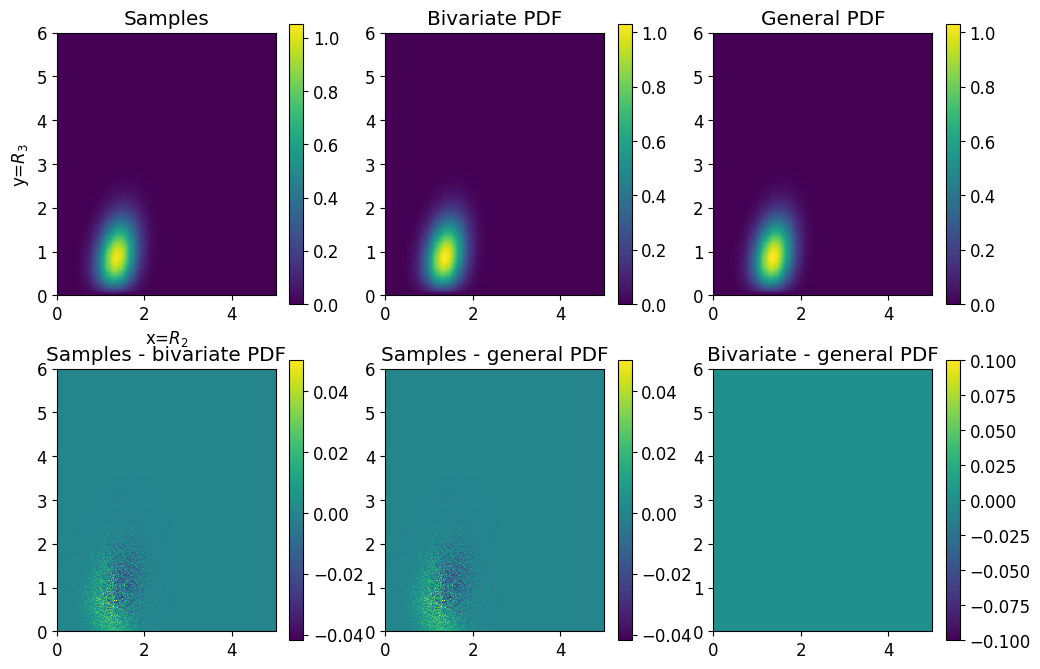

In [9]:
(xmax,ymax) = (x_max,y_max)
xedges = np.linspace(0,xmax,nx+1)
yedges = np.linspace(0,ymax,ny+1)
Hx_emp, xedges, yedges = np.histogram2d(R2_abs, R3_abs, bins=(xedges, yedges),density=True)

# We made the 2D histograms below asymmetric in dimension (remove "extent=[]" to see that),
# and validated labels using 1D histograms above.
# fig,ax=plt.subplots()
# ax.hist2d(R2_abs, R3_abs,bins=50,range=[[0,xmax],[0,ymax]])
# ax.set_aspect('equal')
# ax.set_xlabel(r"$R_2$"); ax.set_ylabel(r"$R_3$")
# plt.show()

plt.figure(figsize=(12,8))                         
plt.subplot(2,3,1)        
plt.imshow(Hx_emp.T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax]) 
plt.xlabel(r"x=$R_2$"); plt.ylabel(r"y=$R_3$")
plt.title("Samples"); plt.colorbar(); 

plt.subplot(2,3,2)        
plt.imshow(result.T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax]) #
plt.title("Bivariate PDF"); plt.colorbar()

plt.subplot(2,3,3)        
plt.imshow(result_2.T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax]) #
plt.title("General PDF"); plt.colorbar()

plt.subplot(2,3,4)
plt.imshow((Hx_emp-result).T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax])
plt.title("Samples - bivariate PDF"); plt.colorbar(); 

plt.subplot(2,3,5)
plt.imshow((Hx_emp-result_2).T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax])
plt.title("Samples - general PDF"); plt.colorbar(); 

plt.subplot(2,3,6)
plt.imshow((result-result_2).T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax])
plt.title("Bivariate - general PDF"); plt.colorbar(); plt.show()

We see that the synthetic data, the ```bivariate_Rice_DAG``` PDF, and the general PDF ```dag_pgm_tools.RiceWoolfson_for_DAG.prob()``` yield consistent results.

# 2. Specifications of a general tree

Let's examine the joint PDF of the following graph, for example:

<img src="dag_img/complex_dag_v2.png" alt="complex dag" width="300"/>

In [10]:
(r, rx, rt)   = (0.9, 0.9, 0.9)
node_labels   = ["Fref", "Foff", "Ft1s1", "Ft2s1", "Ft1s2", "Ft2s2", "Ft1s3", "Ft2s3"]
nodes         = range(len(node_labels))
root          = 0 # root of the tree
edges         = [(0,1),(1,2),(2,3),(1,4),(4,5),(1,6),(6,7)]
rdw           = [r,    rx,   rt,   rx,   rt,   rx,   rt   ] 
edge_labels   = [(node_labels[edges[e][0]], node_labels[edges[e][1]]) for e in range(len(edges))]

G=networkx.DiGraph()
G.add_nodes_from(node_labels)                            
G.add_edges_from(edge_labels)
print(f"Is this a valid tree? {networkx.is_arborescence(G)}.")

Is this a valid tree? True.


#### Visualization
Perhaps gratuitously, two ways of visually inspecting the tree...

In [11]:
# pos = graphviz_layout(G, prog="neato")
# plt.figure(figsize=(5,5))
# networkx.draw(G, pos, arrows=True,node_color='w', edgecolors='k',node_size=1500, with_labels = True)
# plt.show()

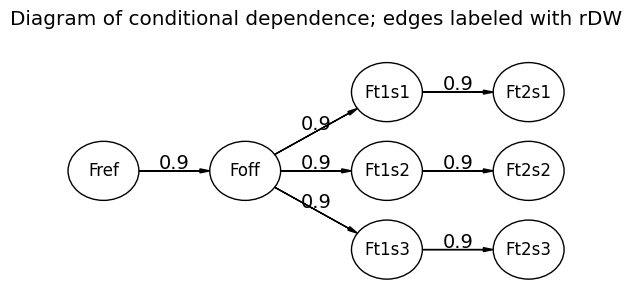

In [12]:
pgm = draw_tree.prepare_tree_pgm(nodes, edges, node_labels, rdw, root)
pgm.render()
plt.title(f"Diagram of conditional dependence; edges labeled with rDW\n")
plt.show()

## Sampling from Distributions on Directed Acyclic Graphs
Chapter 10 of Kevin Murphy's _Machine Learning: a Probabilistic Perspective_ describes how one can sample from Directed Gaussian Graphical Models, which is a productive way of sampling from sets of normalized structure factors with correlations described by the models above. This section is not essential but provides us with a benchmark for checking the correctness of the multivariate Wilson distribution described above.

#### Covariance matrix for a gaussian tree
Murphy, section 10.2.5, provides an algorithm for calculating the covariance matrix of a Gaussian tree. Let's check it!

In [13]:
# to avoid renaming...
list_of_rdw   = rdw
list_of_edges = edges
list_of_nodes = nodes
n_nodes       = 8
n_edges       = len(list_of_rdw)

# The following implements Murphy, eqs. 10.15-10.22
# W_ts = rdw if edge s -> t
W = np.zeros((n_nodes, n_nodes))
S = np.zeros((n_nodes, n_nodes))
for i in range(n_edges):
    W[list_of_edges[i][1], list_of_edges[i][0]] = list_of_rdw[i] # the indices are not the other way around
                                                                 # this is consistent with the definition given below  
                                                                 # eq 10.15 "w_ts is the strength of the s → t edge"

S[0,0]=np.sqrt(0.5) # this is not explicit in Murphy but essential
for i in range(n_edges):
    S[list_of_edges[i][1],list_of_edges[i][1]] = np.sqrt(0.5*(1-list_of_rdw[i]**2))

U = np.linalg.inv(np.eye(n_nodes)-W)
Sig_DAG = np.matmul(np.matmul(U,S),np.transpose(np.matmul(U,S)))

# for this example, I worked the matrix out by hand as well:
Sig_full = [[1,r,r*rx,r*rx*rt,r*rx,r*rx*rt,r*rx,r*rx*rt],\
            [r,1,rx,rx*rt,rx,rx*rt,rx,rx*rt],\
            [rx*r,rx,1,rt,rx*rx,rx*rx*rt,rx*rx,rx*rx*rt],\
            [rt*rx*r,rt*rx,rt,1,rt*rx*rx,rt*rx*rx*rt,rt*rx*rx,rt*rx*rx*rt],\
            [rx*r,rx,rx*rx,rx*rx*rt,1,rt,rx*rx,rx*rx*rt],\
            [rt*rx*r,rt*rx,rt*rx*rx,rt*rx*rx*rt,rt,1,rt*rx*rx,rt*rx*rx*rt],\
            [rx*r,rx,rx*rx,rx*rx*rt,rx*rx,rx*rx*rt,1,rt],\
            [rt*rx*r,rt*rx,rt*rx*rx,rt*rx*rx*rt,rt*rx*rx,rt*rx*rx*rt,rt,1]
           ]
Sig_full = 0.5*np.array(Sig_full)

print("By hand...")
print(np.array2string(Sig_full,precision=3))
print('\n And now by Murphy\'s eqns:')
print(np.array2string(Sig_DAG,precision=3))
# plt.imshow(Sig_full-Sig_DAG)
# plt.title(r"$\Delta$Cov (by hand - Murphy)",fontsize=12)
# plt.colorbar()
# plt.show()

By hand...
[[0.5   0.45  0.405 0.365 0.405 0.365 0.405 0.365]
 [0.45  0.5   0.45  0.405 0.45  0.405 0.45  0.405]
 [0.405 0.45  0.5   0.45  0.405 0.365 0.405 0.365]
 [0.365 0.405 0.45  0.5   0.365 0.328 0.365 0.328]
 [0.405 0.45  0.405 0.365 0.5   0.45  0.405 0.365]
 [0.365 0.405 0.365 0.328 0.45  0.5   0.365 0.328]
 [0.405 0.45  0.405 0.365 0.405 0.365 0.5   0.45 ]
 [0.365 0.405 0.365 0.328 0.365 0.328 0.45  0.5  ]]

 And now by Murphy's eqns:
[[0.5   0.45  0.405 0.365 0.405 0.365 0.405 0.365]
 [0.45  0.5   0.45  0.405 0.45  0.405 0.45  0.405]
 [0.405 0.45  0.5   0.45  0.405 0.365 0.405 0.365]
 [0.365 0.405 0.45  0.5   0.365 0.328 0.365 0.328]
 [0.405 0.45  0.405 0.365 0.5   0.45  0.405 0.365]
 [0.365 0.405 0.365 0.328 0.45  0.5   0.365 0.328]
 [0.405 0.45  0.405 0.365 0.405 0.365 0.5   0.45 ]
 [0.365 0.405 0.365 0.328 0.365 0.328 0.45  0.5  ]]


Let's implement these as functions

In [14]:
def Cov_from_DAG_acentric(list_of_nodes, list_of_edges, list_of_rdw, mu_per_node=0, Sigma=1, as_block=True):
    '''
    Calculating the covariance of the JPD of a directed acyclic graph of acentric structure factors.
    This implements Murphy, eqs. 10.15-10.22
    Input arguments:
    list_of_nodes : List of indices of nodes to be used in calculating the JPD
    list_of_edges : List of tuples (from, to) summarizing conditional dependencies
    list_of_rdw   : List of double-Wilson parameters (floats) corresponding to each edge
    mu_per_node   : List of floats; unconditional expectation values for each node (default: 0)
    Sigma         : Float, default expectation value <F**2> (Default: 1)
    as_block      : Boolean; whether to return a block matrix with covariances for real and 
                    imaginary components (Default: True).
    '''
    n_nodes = len(list_of_nodes)
    n_edges = len(list_of_edges)

    W = np.zeros((n_nodes, n_nodes))
    S = np.zeros((n_nodes, n_nodes))
    for i in range(n_edges):
        W[list_of_edges[i][1], list_of_edges[i][0]] = list_of_rdw[i]

    S[0,0]=np.sqrt(0.5*Sigma) # this is not explicit in Murphy but essential
    for i in range(n_edges):
        S[list_of_edges[i][1],list_of_edges[i][1]] = np.sqrt(0.5*(1-list_of_rdw[i]**2))

    U = np.linalg.inv(np.eye(n_nodes)-W)
    Sig_DAG = np.matmul(np.matmul(U,S),np.transpose(np.matmul(U,S)))
    
    if as_block:
        return np.block([[Sig_DAG,np.zeros((n_nodes,n_nodes))],[np.zeros((n_nodes,n_nodes)),Sig_DAG]])
    else:
        return Sig_DAG

def Cov_from_DAG_centric( list_of_nodes, list_of_edges, list_of_rdw, mu_per_node=0, Sigma=1):
    '''
    Calculating the covariance of the JPD of a directed acyclic graph of acentric structure factors.
    This implements Murphy, eqs. 10.15-10.22
    Input arguments:
    list_of_nodes : List of indices of nodes to be used in calculating the JPD
    list_of_edges : List of tuples (from, to) summarizing conditional dependencies
    list_of_rdw   : List of double-Wilson parameters (floats) corresponding to each edge
    mu_per_node   : List of floats; unconditional expectation values for each node (default: 0)
    Sigma         : Float, default expectation value <F**2> (Default: 1)
    '''
    return Cov_from_DAG_acentric(list_of_nodes, list_of_edges, list_of_rdw, mu_per_node, Sigma=2*Sigma, as_block=False)

In [15]:
print(np.array2string(Cov_from_DAG_acentric(list_of_nodes, list_of_edges, list_of_rdw, mu_per_node=0, as_block=False),\
                      precision=3))

[[0.5   0.45  0.405 0.365 0.405 0.365 0.405 0.365]
 [0.45  0.5   0.45  0.405 0.45  0.405 0.45  0.405]
 [0.405 0.45  0.5   0.45  0.405 0.365 0.405 0.365]
 [0.365 0.405 0.45  0.5   0.365 0.328 0.365 0.328]
 [0.405 0.45  0.405 0.365 0.5   0.45  0.405 0.365]
 [0.365 0.405 0.365 0.328 0.45  0.5   0.365 0.328]
 [0.405 0.45  0.405 0.365 0.405 0.365 0.5   0.45 ]
 [0.365 0.405 0.365 0.328 0.365 0.328 0.45  0.5  ]]


We could sample from the full joint PDF or condition on, for example, the $F^{ref}$.

In [16]:
# We will assume that each node has a single parent.
Eref=1.5
Sig_cond  = Sig_full[1:n_nodes,1:]-np.matmul(Sig_full[1:,0].reshape(-1,1),Sig_full[0,1:].reshape(1,-1))/Sig_full[0,0]
mean_cond = np.matmul(Sig_full[1:,0].reshape(-1,1),np.linalg.inv(Sig_full[0,0].reshape(1,-1)))*Eref
print(Sig_cond)

[[0.095     0.0855    0.07695   0.0855    0.07695   0.0855    0.07695  ]
 [0.0855    0.17195   0.154755  0.07695   0.069255  0.07695   0.069255 ]
 [0.07695   0.154755  0.2342795 0.069255  0.0623295 0.069255  0.0623295]
 [0.0855    0.07695   0.069255  0.17195   0.154755  0.07695   0.069255 ]
 [0.07695   0.069255  0.0623295 0.154755  0.2342795 0.069255  0.0623295]
 [0.0855    0.07695   0.069255  0.07695   0.069255  0.17195   0.154755 ]
 [0.07695   0.069255  0.0623295 0.069255  0.0623295 0.154755  0.2342795]]


#### Sampling from the unconditional MVN of the DAG for acentric (complex) structure factors
We'll specialize right away to all unconditional means = 0; since that is the only case that matters for crystallography. Otherwise, see Murphy and [Wikipedia](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) for information on more complete expressions.

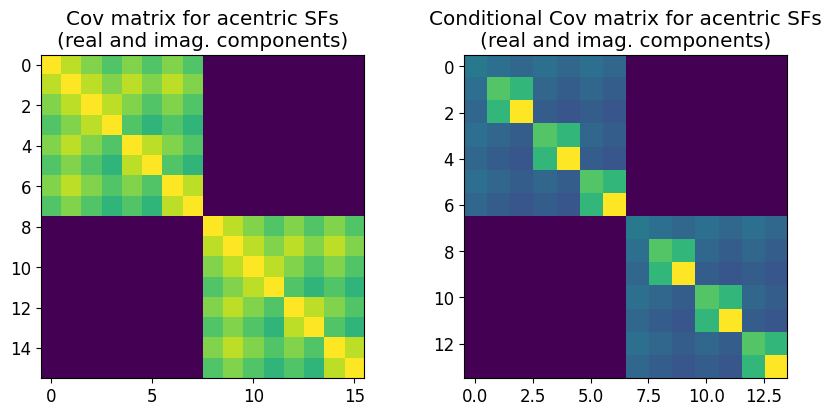

In [17]:
# Unconditional (each marginal distribution should be a Wilson distribution):
mu_full = np.zeros((2*n_nodes,))
Cov_from_DAG_acentric_full = Cov_from_DAG_acentric(list_of_nodes, list_of_edges, list_of_rdw, as_block=True)

# Conditional on an observation for F_ref (node 0):
S                          = Cov_from_DAG_acentric(list_of_nodes, list_of_edges, list_of_rdw, as_block=False)
S_cond =  S[1:n_nodes,1:]-np.matmul(S[1:,0].reshape(-1,1),S[0,1:].reshape(1,-1))/S[0,0]
Cov_from_DAG_acentric_cond = np.block([[S_cond, np.zeros((n_nodes-1,n_nodes-1))],\
                                       [np.zeros((n_nodes-1,n_nodes-1)), S_cond]])
E0 = 1.5 # value of 0th structure factor amplitude that we're conditioning on
         # we will assume that phi(0) = 0 without loss of generality
mu_cond = np.block([np.matmul(S[1:,0].reshape(-1,1),np.linalg.inv(S[0,0].reshape(1,-1)))*E0,\
                    np.matmul(S[1:,0].reshape(-1,1),np.linalg.inv(S[0,0].reshape(1,-1)))*0]).ravel('F')
if True:
    plt.figure(figsize=(10,4.2))                         
    plt.subplot(1,2,1)  
    plt.imshow(Cov_from_DAG_acentric_full)
    plt.title("Cov matrix for acentric SFs\n(real and imag. components)")
    # plt.colorbar()
    plt.subplot(1,2,2)  
    plt.imshow(Cov_from_DAG_acentric_cond)
    plt.title("Conditional Cov matrix for acentric SFs\n(real and imag. components)")
    # plt.colorbar()
    plt.show() # graphical check

Note that the conditional covariance matrix is smaller as the real and imaginary components of the root of the tree have been omitted.

We can now draw samples from these unconditional and conditional joint probability distributions for the real and imaginary components of these (complex) structure factors.

#### Sampling from the unconditional MVN for acentric structure factors (according to the DAG above)
MVN = multivariate normal

In [18]:
n_samples = 1000000
vals = rng.multivariate_normal(mu_full,Cov_from_DAG_acentric_full,n_samples)

phi   = np.zeros((n_samples, n_nodes))
R_sq  = np.zeros((n_samples, n_nodes))
R_abs = np.zeros((n_samples, n_nodes))
for i in range(n_nodes):
    phi[  :,i] = np.angle(vals[:,i] + 1j*vals[:,n_nodes+i])
    R_sq[ :,i] = vals[:,i]**2 + vals[:,n_nodes+i]**2
    R_abs[:,i] = np.abs(vals[:,i] + 1j*vals[:,n_nodes+i])

#### Sampling from the _conditional_ MVN for acentric structure factors (according to the DAG above)
Conditional on $E_0$:

In [19]:
n_samples = 1000000
n_nodes_cond = n_nodes-1
vals = rng.multivariate_normal(mu_cond,Cov_from_DAG_acentric_cond,n_samples)

phi_cond   = np.zeros((n_samples, n_nodes_cond))
R_sq_cond  = np.zeros((n_samples, n_nodes_cond))
R_abs_cond = np.zeros((n_samples, n_nodes_cond))
for i in range(n_nodes-1):
    phi_cond[  :,i] = np.angle(vals[:,i]    + 1j*vals[:,n_nodes_cond+i])
    R_sq_cond[ :,i] =          vals[:,i]**2 +    vals[:,n_nodes_cond+i]**2
    R_abs_cond[:,i] = np.abs(  vals[:,i]    + 1j*vals[:,n_nodes_cond+i])

### Factorizing the joint probability for SF amplitudes on trees--the multivariate Wilson distribution

As we saw in "_Factorizing the joint probability_" for the bivariate case, the results of _both_ integrals are Rice distributions. The above principle generalizes to directed trees since the phase difference between a node and its parent can be separately integrated out for each edge. As before, we can use polar coordinates to represent the complex structure factors, $E_i=(R_i,\phi_i)$. Let's mark the parent of each node $R_i$ as $\mathrm{Pa}(R_i)$; let the "origin" be $R_0$, and refer to the DW parameter for $P\left(R_i \bigr| \mathrm{Pa}(R_i)\right)$ as $r_i$, then,

$$
P\left(R_i \bigr| \mathrm{Pa}(R_i)\right) = \int d\Delta\phi_{i,\mathrm{Pa}(i)} P\left(R_i,\Delta\phi_{i,\mathrm{Pa(i)}}\bigr| \mathrm{Pa}(R_i)\right) = Rice\left(\nu = r_i \mathrm{Pa}(R_i), \sigma^2 = \frac{\Sigma}{2}(1-r_i^2)\right)
$$
and

$$
P\left(\{R_i: \ i>0\} \bigr| R_0\right) = \prod_{i>0} Rice\left(\nu = r_i \mathrm{Pa}(R_i), \sigma^2 = \frac{\Sigma}{2}(1-r_i^2)\right)
$$

That is, to specify a joint probability density function (PDF) on the amplitudes, all we need to do is to specify the the PDF for the root(s) of the tree, the tree structure $\left\{\left(i, \mathrm{Pa}(i)\right)\right\}$, and estimates of the $r_i$. In the limit of $r_i\rightarrow 0$, the PDF of the child node (a "leaf") returns to the Wilson distribution. 

#### Centric case:
$$
P\left(R_i \bigr| \mathrm{Pa}(R_i)\right) = \int d\Delta\phi_{i,\mathrm{Pa}(i)} P\left(R_i,\Delta\phi_{i,\mathrm{Pa(i)}}\bigr| \mathrm{Pa}(R_i)\right) = \mathrm{FoldedNormal}\left(\nu = r_i \mathrm{Pa}(R_i), \sigma^2 = \Sigma(1-r_i^2)\right)
$$
and

$$
P\left(\{R_i: \ i>0\} \bigr| R_0\right) = \prod_{i>0} \mathrm{FoldedNormal}\left(\nu = r_i \mathrm{Pa}(R_i), \sigma^2 = \Sigma(1-r_i^2)\right)
$$

Together, we will refer to these expressions as the **multivariate Wilson distribution**. These joint probability distributions are implemented in ```dag_pgm_tools.RiceWoolfson_for_DAG```, along with methods for sampling from them.

#### Sampling using the Multivariate Wilson distribution

We implemented the priors on structure factor amplitudes for arbitrary DAGs (or trees, to be precise) in ```dw_tools/dag_pgm_tools.py```. This implementation uses the ```scipy.stats``` parametrization of the Rice and folded normal distributions. See **notebook 5** for details on parsing parameters for the Rice and folded normal distributions.

In [20]:
# a test for the PDF calculation for a single edge
daughter_dist=dag_pgm_tools.RiceWoolfson_from_parent(parent_R=np.array([1,1.5,2]), rDW=np.array([0.2,0.4,0.8]), \
                                                     Sigma=1, centric=False)
print(daughter_dist.mean())
print(daughter_dist.variance())
print(daughter_dist.stddev())
print(daughter_dist.sample((3,)))
# print(daughter_dist.log_prob(np.linspace(0,4,10)))
# print(daughter_dist.prob(np.linspace(0,4,10)))

[0.88631797 0.97759167 1.65738242]
[0.21444046 0.24431452 0.17308353]
[0.46307716 0.49428183 0.41603309]
[1.13349217 0.65043718 1.77696037]


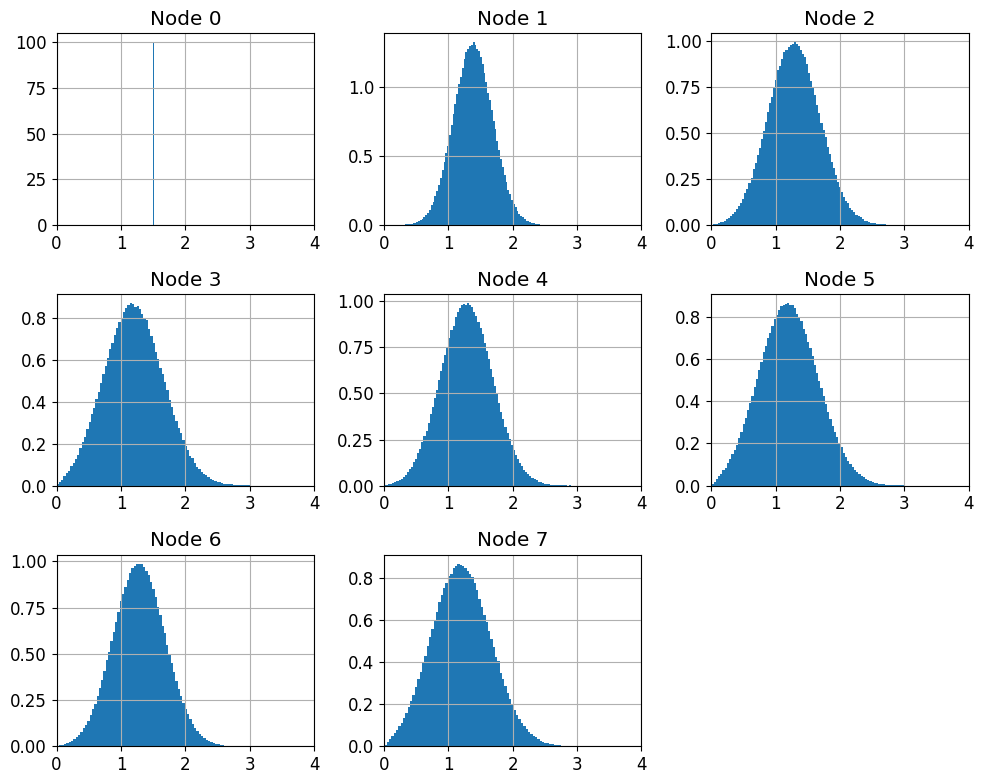

In [21]:
# a test for the PDF calculation for the entire graph
tmp=dag_pgm_tools.RiceWoolfson_for_DAG(list_of_nodes, list_of_edges, root, list_of_rdw, \
                         root_R=np.array([1.5,3.]), root_rDW=list_of_rdw[0], Sigma=1, centric=False)
my_samples = tmp.sample(1000000)

refl_id = 0
plt.figure(figsize=(10,8))                         
for node_id in range(n_nodes):
    plt.subplot(3,3,node_id+1) 
    plt.hist(my_samples[node_id, refl_id,:].flatten(),100,density=True)
    plt.title(f"Node {node_id}")
    plt.xlim((0,4))
    plt.grid()
    
plt.tight_layout()
plt.show()

#### Graphical comparison of sampling methods
As a last check, we compare amplitudes calculated from the multivariate normal of complex structure factors above with calculated probabilities based on the multivariate Wilson distribution. We find agreement within sampling/discretization error.

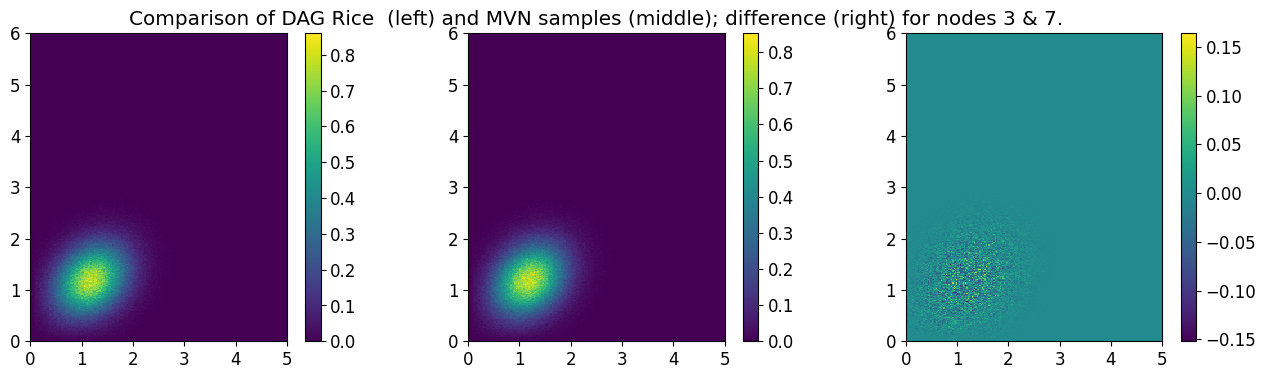

In [23]:
node_1  = 3
node_2  = 7
refl_id = 0
(xmax,ymax) = (x_max,y_max)
xedges = np.linspace(0,xmax,nx+1)
yedges = np.linspace(0,ymax,ny+1)
Hx_rice_samples, xedges, yedges = np.histogram2d(my_samples[node_1, refl_id,:].flatten(), \
                                                 my_samples[node_2, refl_id,:].flatten(), \
                                                 bins=(xedges, yedges),density=True)
Hx_mvn_samples,  xedges, yedges = np.histogram2d(R_abs_cond[:,node_1-1].flatten(), \
                                                 R_abs_cond[:,node_2-1].flatten(), \
                                                 bins=(xedges, yedges),density=True)

# Since the axes of these plots drive me nuts, a positive control using [yplot.hist2d.
# In addition, I made the 2D histograms below asymmetric in dimension (remove "extent=[]" to see that),
# and validated labels using 1D histograms above.
# fig,ax=plt.subplots()
# ax.hist2d(R2_abs, R3_abs,bins=50,range=[[0,xmax],[0,ymax]])
# ax.set_aspect('equal')
# ax.set_xlabel(r"$R_2$"); ax.set_ylabel(r"$R_3$")
# plt.show()

plt.figure(figsize=(16,4))                         
plt.subplot(1,3,1)        
plt.imshow(Hx_rice_samples.T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax]) 
plt.colorbar(); 

plt.subplot(1,3,2)        
plt.imshow(Hx_mvn_samples.T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax]) #
plt.colorbar()
plt.title("Comparison of DAG Rice  (left) and MVN samples (middle); difference (right) for nodes "\
          + str(node_1) + " & " +str(node_2) + ".")

plt.subplot(1,3,3)        
plt.imshow(Hx_mvn_samples.T - Hx_rice_samples.T, interpolation='none',origin='lower', extent=[0,xmax,0,ymax]) #
plt.colorbar()
plt.show()

Looks pretty consistent!